# This notebook provides interactive widgets to play with the imaging requirements for the SKA1 SDP

## First, do the necessary set-up (run the code block below, first)

In [5]:
""" These first few lines below import the IPython definitions and methods that we will use. 
Please Refer to ipython_api.py for the implementation """
from IPython.html.widgets import interact, interactive, fixed
from IPython.html.widgets.interaction import interact_manual
from IPython.html import widgets
from api_ipython import IPythonAPI as iapi
from parameter_definitions import *
from implementation import Implementation as imp
import sympy.physics.units as u

%matplotlib inline

# The lines below define the available telescopes, bands and modes that may be chosen.

available_teles = (Telescopes.SKA1_Low, Telescopes.SKA1_Low_old, Telescopes.SKA1_Mid, Telescopes.SKA1_Mid_old, 
                   Telescopes.SKA1_Sur_old, Telescopes.SKA2_Low, Telescopes.SKA2_Mid)
available_bands = (Bands.Low, 
                   Bands.Mid1, Bands.Mid2, Bands.Mid5A, Bands.Mid5B, 
                   Bands.Sur1)
available_modes     = (ImagingModes.Continuum, ImagingModes.Spectral, ImagingModes.SlowTrans)
available_modes_all = (ImagingModes.Continuum, ImagingModes.Spectral, ImagingModes.SlowTrans, ImagingModes.All)
verbose_display = False

## Using default values, we can compare telescopes side-by-side

Telescope,SKA1_Low_rebaselined,SKA1_Low_old,
Band,Low,Low,
Mode,Continuum,Continuum,
Baseline Dependent Time Avg.,True,True,
Max Baseline,80,100,km
Max # channels,65536,256000,
Optimal Number of Facets,2,2,
Optimal Snapshot Time,53.8,36.8,sec.
Visibility Buffer,0.742,3.45,PetaBytes
Working (cache) memory,0.188,0.367,TeraBytes
Image side length,16719,20899,pixels


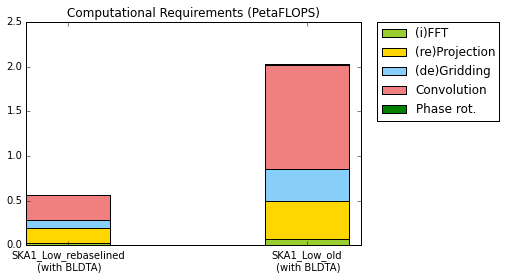

In [2]:
Tel1_BLDTA = False  #baseline dependent time averaging (initial default value, can be toggled interactively)
Tel2_BLDTA = False
interact_manual(iapi.compare_telescopes_default, 
                Telescope_1=available_teles, Telescope_2=available_teles, Band_1=available_bands,
                Band_2=available_bands, Mode_1=available_modes_all, Mode_2=available_modes_all,
                Tel1_BLDTA=Tel1_BLDTA, Tel2_BLDTA=Tel2_BLDTA, verbose=verbose_display);

## We can also interactively play with parameters (via sliders)

### The first option is automatic updating of results as the sliders are moved. This may be sluggish

In [3]:
BL_dep_time_av = False  #baseline dependent time averaging (initial default value, can be toggled interactively)
interact(iapi.evaluate_telescope_manual, max_baseline=(10,200), Nf_max = (1,256000,1), Nfacet=(1,10,1), Tsnap=(1.2,1800), 
         Telescope=available_teles, Band=available_bands, Mode=available_modes, BL_dep_time_av=BL_dep_time_av, 
         verbose=verbose_display);

Max Baseline,124 km
Max # of channels,128000
Telescope,SKA1_Mid_rebaselined
Band,Mid1
Mode,Spectral
Tsnap,900.6 sec
Nfacet,5


Visibility Buffer,39.7 PetaBytes
Working (cache) memory,3.55 TeraBytes
Image side length,13437 pixels
I/O Rate,57.5 TeraBytes/s
Total Compute Requirement,5.23 PetaFLOPS
-> Gridding,0.545 PetaFLOPS
-> FFT,0.264 PetaFLOPS
-> Projection,1.73 PetaFLOPS
-> Convolution,2.55 PetaFLOPS
-> Phase Rotation,0.144 PetaFLOPS


### The second option is manual triggering of recompute events (recommended). 

#### This allows more conveniently computing elaborate (slow) optimizations and visualizations per computation, as these are only run when required
#### In this example, *Tsnap and Nfacet* are *automatically* chosen so as to minimize the value of Rflop

Max Baseline,142 km
Max # of channels,128000
Telescope,SKA1_Mid_rebaselined
Band,Mid2
Mode,Spectral


Optimal Number of Facets,3
Optimal Snapshot Time,1.59e+03 sec.
Visibility Buffer,45.5 PetaBytes
Working (cache) memory,35.2 TeraBytes
Image side length,25646 pixels
I/O Rate,23.7 TeraBytes/s
Total Compute Requirement,4.04 PetaFLOPS
-> Gridding,0.973 PetaFLOPS
-> FFT,0.21 PetaFLOPS
-> Projection,1.43 PetaFLOPS
-> Convolution,1.36 PetaFLOPS


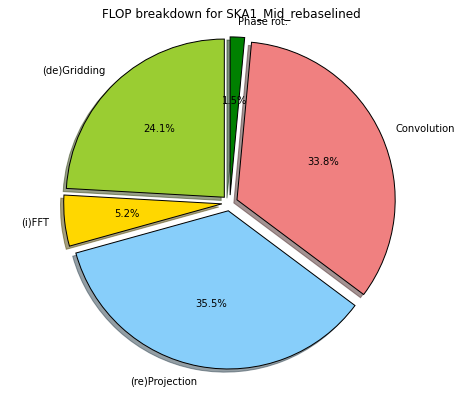

In [6]:
BL_dep_time_av = False  #baseline dependent time averaging (initial default value, can be toggled interactively)
interact_manual(iapi.evaluate_telescope_optimized, max_baseline=(10,200), Nf_max = (1,256000,1), Telescope=available_teles, 
         Band=available_bands, Mode=available_modes, BL_dep_time_av=BL_dep_time_av, verbose=verbose_display);

## illustrating 1D "parameter sweep" + visualization functionality.

Starting sweep of parameter Bmax, evaluating expression Rflop over range (40, 80) in 5 steps (i.e. 6 data points)
> 0.0% done: Evaluating Rflop for Bmax = 40.0
> 16.7% done: Evaluating Rflop for Bmax = 48.0
> 33.3% done: Evaluating Rflop for Bmax = 56.0
> 50.0% done: Evaluating Rflop for Bmax = 64.0
> 66.7% done: Evaluating Rflop for Bmax = 72.0
> 83.3% done: Evaluating Rflop for Bmax = 80.0
done with parameter sweep!


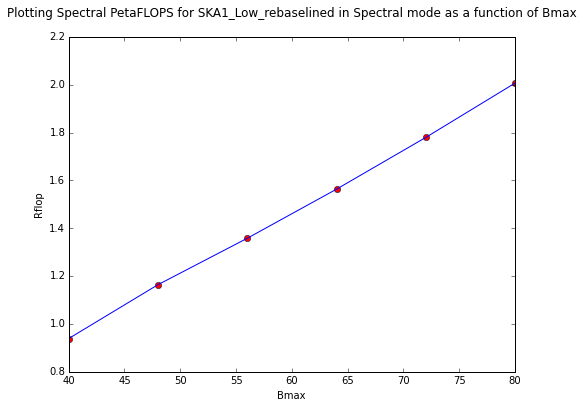

In [7]:
from IPython.display import display, HTML

expression = 'Rflop'
parameter = 'Bmax'
param_val_min = 40
param_val_max = 80
unit_string = "u.km"
number_steps = 5
telescope = Telescopes.SKA1_Low
immode = ImagingModes.Spectral
band=Bands.Low

display(HTML('<font color="blue">Computing the result -- this may take several (tens of) seconds.</font>'))
(param_values, results) = iapi.eval_param_sweep_1d(telescope, immode, band=band, 
                                                   expression=expression, parameter=parameter, param_val_min=param_val_min,
                                                   param_val_max=param_val_max, number_steps=number_steps, 
                                                   unit_string=unit_string, verbose=False)
header = 'Plotting Spectral PetaFLOPS for %s in %s mode as a function of %s' % (telescope, immode, parameter)
iapi.plot_line_datapoints(header, param_values, np.array(results)/u.peta, xlabel=parameter, ylabel=expression)

## illustrating 2D "parameter sweep" + visualization functionality.

Evaluating expression Rflop while
sweeping parameters Na and Bmax over 2D domain [100, 512] x [40, 80] in 5 steps each,
for a total of 36 data evaluation points
> 0.0% done: Evaluating Rflop for (Na, Bmax) = (100, 40000*m)
> 2.8% done: Evaluating Rflop for (Na, Bmax) = (100, 48000*m)
> 5.6% done: Evaluating Rflop for (Na, Bmax) = (100, 56000*m)
> 8.3% done: Evaluating Rflop for (Na, Bmax) = (100, 64000*m)
> 11.1% done: Evaluating Rflop for (Na, Bmax) = (100, 72000*m)
> 13.9% done: Evaluating Rflop for (Na, Bmax) = (100, 80000*m)
> 16.7% done: Evaluating Rflop for (Na, Bmax) = (182.4, 40000*m)
> 19.4% done: Evaluating Rflop for (Na, Bmax) = (182.4, 48000*m)
> 22.2% done: Evaluating Rflop for (Na, Bmax) = (182.4, 56000*m)
> 25.0% done: Evaluating Rflop for (Na, Bmax) = (182.4, 64000*m)
> 27.8% done: Evaluating Rflop for (Na, Bmax) = (182.4, 72000*m)
> 30.6% done: Evaluating Rflop for (Na, Bmax) = (182.4, 80000*m)
> 33.3% done: Evaluating Rflop for (Na, Bmax) = (264.8, 40000*m)
> 36.1% do

C:\Anaconda\lib\site-packages\matplotlib\text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
C:\Anaconda\lib\site-packages\matplotlib\text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


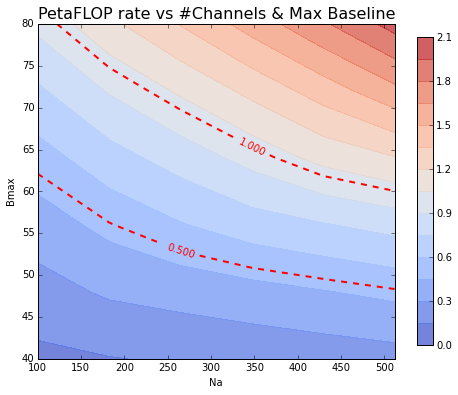

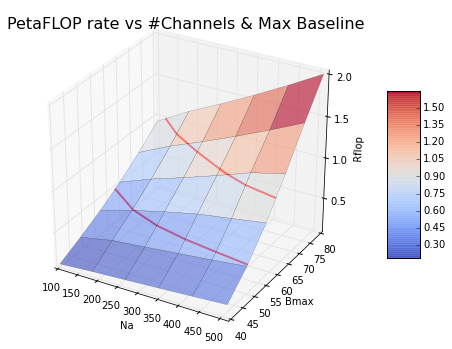

In [8]:
from IPython.display import display, HTML

telescope = Telescopes.SKA1_Low
band = Bands.Low
immode = ImagingModes.Spectral
expression = 'Rflop'
parameters = ('Na', 'Bmax')
unit_strings = (None, 'u.km')
parameter_ranges = ((100,512),(40,80))
number_steps = 5
verbose = False

display(HTML('<font color="blue">Computing the result -- this may take several (tens of) seconds.</font>'))
(p1_values, p2_values, results) = iapi.eval_param_sweep_2d(telescope, immode, band=band, 
                                                           expression=expression, parameters=parameters, 
                                                           params_ranges=parameter_ranges, number_steps=number_steps, 
                                                           unit_strings=unit_strings, verbose=verbose)


iapi.plot_2D_surface('PetaFLOP rate vs #Channels & Max Baseline', p1_values, p2_values, results/1e15, xlabel=parameters[0], 
                     ylabel=parameters[1], contours=np.array((0.5, 1.0)))
iapi.plot_3D_surface('PetaFLOP rate vs #Channels & Max Baseline', p1_values, p2_values, results/1e15, xlabel=parameters[0], 
                     ylabel=parameters[1], zlabel=expression, contours=np.array((0.5, 1.0)))